# 1-D Convolutional Networks for Phoneme Recognition
Architecture inspired by https://arxiv.org/pdf/1707.01836.pdf

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from scipy import signal
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import sys
sys.path.append('../../')

from speech2phone.preprocessing.TIMIT.phones import get_data, get_phones, phones

### Load Data

In [3]:
def resample(data, y):
    """Resample audio to 800 points."""
    return signal.resample(data, 800), y

def resample512(data, y):
    return signal.resample(data, 512), y

def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(k=maxk, dim=1)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k / batch_size)
        return res

In [4]:
import os
print(os.getcwd())
print(os.path.abspath('../TIMIT/TIMIT'))

audio, labels = get_data(preprocessor=resample, batch_preprocess=False, TIMIT_root='../TIMIT/TIMIT', padding=500)
phonemes = get_phones(labels)
n_phones = len(phones)

/mnt/pccfs/backed_up/jaredtn/speech2phone/experiments
/mnt/pccfs/backed_up/jaredtn/speech2phone/TIMIT/TIMIT
Loading train/resample/500 set from cache... done.


In [5]:
audio_tensor = torch.Tensor(audio).unsqueeze(1)
labels_tensor = torch.Tensor(labels)
print(audio_tensor.shape)
print(labels_tensor.shape)

torch.Size([132810, 1, 800])
torch.Size([132810])


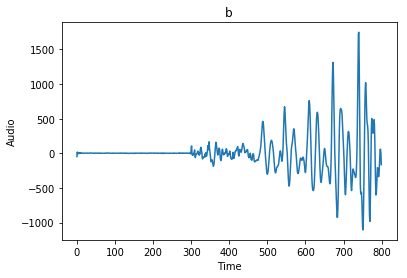

In [6]:
def display_and_save_phoneme(i):
    phoneme, label = audio_tensor[i,0].numpy(), get_phones(int(labels_tensor[i].item()))
    plt.plot(phoneme)
    plt.xlabel("Time")
    plt.ylabel("Audio")
    plt.title(label)
    plt.savefig('phoneme_{}.jpg'.format(label))
    plt.show()
    
display_and_save_phoneme(np.random.randint(100))

### Train/Test Split

In [7]:
full_dataset = TensorDataset(audio_tensor, labels_tensor) # Dataset requires same batch dimension
train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

### Train the Model

In [9]:
class ConvNet1D(nn.Module):
    def __init__(self, num_inputs, num_outputs, kernel_size=15, stride=1, padding=7, conv_dropout=0.2):
        super().__init__()
        self.n_channels = 64
        self.n_embedding = self.n_channels * 25
        print("n_embedding: {}".format(self.n_embedding))
        
        # input (N, 1, 800) - no initial dropout before residual connections
        self.init = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=self.n_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm1d(self.n_channels),
            nn.ReLU()
        )
        
        self.pool4 = nn.AvgPool1d(kernel_size=4)
        self.pool2 = nn.AvgPool1d(kernel_size=2)
        
        # (N, 128, 800)
        self.downsample4 = nn.Sequential(
            nn.Conv1d(in_channels=self.n_channels, out_channels=self.n_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm1d(self.n_channels),
            nn.ReLU(),
            nn.Dropout(conv_dropout),
            nn.Conv1d(in_channels=self.n_channels, out_channels=self.n_channels, kernel_size=kernel_size, stride=4, padding=padding)
        )
        
        # (N, 128, 200)
        
        # apply lots of pooling
        
        # (N, 128, 25)
    
        n_res_blocks = 3
        channel_lengths = [
            self.n_channels * (2 ** (i // 4))
            for i in range(n_res_blocks+1)
        ]
        channel_lengths = [self.n_channels for i in range(n_res_blocks+1)]
#         print(channel_lengths)
        self.convs = nn.ModuleList([nn.Sequential(
            nn.BatchNorm1d(channel_lengths[i]),
            nn.ReLU(),
            nn.Dropout(conv_dropout),
            nn.Conv1d(in_channels=channel_lengths[i], out_channels=channel_lengths[i], kernel_size=kernel_size, stride=1, padding=padding),
            
            nn.BatchNorm1d(channel_lengths[i]),
            nn.ReLU(),
            nn.Dropout(conv_dropout),
            nn.Conv1d(in_channels=channel_lengths[i], out_channels=channel_lengths[i+1], kernel_size=kernel_size, stride=2, padding=padding),
        ) for i in range(n_res_blocks)])
        
        # (N, 128, 25)
        self.predense = nn.Sequential(
            nn.BatchNorm1d(channel_lengths[-1]),
            nn.ReLU()
        )
        self.dense = nn.Linear(self.n_embedding, num_outputs)
    
    def forward(self, x):
        x = self.init(x)
        x = self.pool4(x) + self.downsample4(x)
        
        for conv in self.convs:
            x = self.pool2(x) + conv(x)
#             print(x.shape)
                  
        x = self.predense(x)
        x = x.view(-1, self.n_embedding)
        x = self.dense(x)

        return x
    


model = ConvNet1D(num_inputs=800, num_outputs=61).cuda()
train_loader = DataLoader(train_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=1024)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, verbose=True)
n_epochs = 50
n_print_every = len(train_loader) - 1

print("Batches per Epoch: {}".format(len(train_loader)))

for epoch in range(n_epochs):
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, y_truth = data
        inputs, y_truth = inputs.cuda(), y_truth.long().cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        train_loss = criterion(outputs, y_truth)
        train_loss.backward()
        optimizer.step()
        
        y_pred = torch.argmax(outputs, dim=1)
        train_acc = (y_pred == y_truth).float().mean()

        # print statistics
        running_loss += train_loss.item()
        if i % n_print_every == n_print_every - 1:    # print every 2000 mini-batches
            inputs, y_truth = next(iter(test_loader))
            inputs, y_truth = inputs.cuda(), y_truth.long().cuda()
            outputs = model(inputs)
            test_loss = criterion(outputs, y_truth)
            test_acc1, test_acc3 = accuracy(output=outputs, target=y_truth, topk=(1,3))

            scheduler.step(test_acc1) # anneal the learning rate if no progress for 5 epochs
            
            print('[%d, %5d] train loss: %.3f test loss: %.3f train top1: %.3f, test top1: %.3f, test top3: %.3f' %
                  (epoch + 1, i + 1, running_loss / n_print_every, test_loss, train_acc, test_acc1, test_acc3))
            running_loss = 0.0
            
                            
print("done")

n_embedding: 1600
Batches per Epoch: 934
[1,   933] train loss: 1.692 test loss: 1.351 train top1: 0.656, test top1: 0.569, test top3: 0.841
[2,   933] train loss: 1.240 test loss: 1.165 train top1: 0.750, test top1: 0.620, test top3: 0.867
[3,   933] train loss: 1.099 test loss: 1.116 train top1: 0.766, test top1: 0.646, test top3: 0.889
[4,   933] train loss: 1.020 test loss: 1.062 train top1: 0.766, test top1: 0.648, test top3: 0.896
[5,   933] train loss: 0.972 test loss: 1.038 train top1: 0.781, test top1: 0.658, test top3: 0.889
[6,   933] train loss: 0.932 test loss: 1.018 train top1: 0.797, test top1: 0.679, test top3: 0.898
[7,   933] train loss: 0.903 test loss: 1.017 train top1: 0.773, test top1: 0.663, test top3: 0.909
[8,   933] train loss: 0.876 test loss: 0.996 train top1: 0.781, test top1: 0.687, test top3: 0.907
[9,   933] train loss: 0.854 test loss: 0.995 train top1: 0.789, test top1: 0.672, test top3: 0.910
[10,   933] train loss: 0.835 test loss: 0.999 train top1: 

Best results so far: 66.5% after 10 epochs (no dropout, 5 128-channel kernel-size-4 convolutional layers, 4-kernel avgpool).  
Increasing the number of convolution channels from 64 to 128 works quite well, with limited signs of overfitting.
Increasing the learning rate from 1e-4 to 1e-3 boosted things as well (66.2% after 5 epochs).  
I'm experimenting with skip connections; hopefully they'll help!  
Dropout just makes things worse.  
model.eval() makes things worse. That's because of how it interacts with the BatchNorm layer; it uses the stored mean/var instead of computing batch statistics.  

Better results!!! 67.7% after 10 epochs (dropout 0.5, 5 layers of 64-channel 16-size-kernel convolutional layers).  
Removing residual connections gave 68.1% after 10 epochs. Probably just noise though.  

Copying the "Cardiologist-Level Arrhythmia Detection" provided 70.0% accuracy after 10 epochs, with dropout 0.5 and Adam lr 3e-3, 64-channel 16-size-kernel convolutional layers.  
Using ReduceLROnPlateau with patience 2 also helped, as did reducing conv_dropout from 0.5 to 0.2, as in their paper. 70.7% accuracy after 10.
Bumping the Adam learning rate up from 1e-3 to 1e-2, combined with ReduceLROnPlateau, gave us 73.0% accuracy after 10 epochs.  

Large batch sizes work well. batch size 32 converges at 67.7%, batch size 128 converges at 73.0%, batch size 256 converges at 75.7%, batch size 512 converges at 73.8%, batch size 1024 converges at 75.9%, batch size 2048 converges at 73.7%.  
Batch size 512 converges significantly slower, taking 12 epochs to cross 70%.

In [ ]:
print([p.numel() for p in model.parameters()]) # Number of parameters in each layer